## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

mkdir: cannot create directory ‘./ckpts’: File exists


In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

### Config

In [3]:
LR = 5e-5
EPOCHS = 300
BATCH_SIZE = 12
CROP_SIZE = 1024+256 # 1024+256=1280
IMAGE_SIZE = 512
Z_DIMS = 24
TRAIN_FRAGMENTS = ["2", "3"]
TEST_FRAGMENT = "1"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000


# take random Z_DIMS integers between 0 and Z_END, without repeating
# z = np.random.choice(np.arange(Z_END), Z_DIMS, replace=False)
# fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, z]
# imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
# Video("fragment_crop.mp4", height=256, width=256)

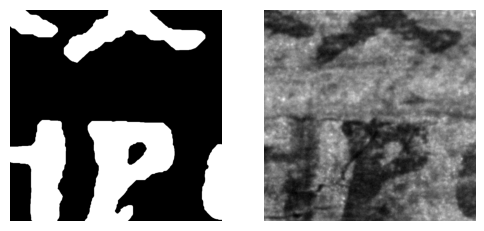

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:

augm_list = [
            A.RandomSizedCrop(min_max_height=(1024, CROP_SIZE), height=CROP_SIZE, width=CROP_SIZE, always_apply=True),
            A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1.0),
            # A.RandomScale(scale_limit=0.15, p=0.5),
            
            
            
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Cutout(max_h_size=int(IMAGE_SIZE * 0.02),
                     max_w_size=int(IMAGE_SIZE * 0.02), num_holes=4, p=0.9),
            A.Rotate(limit=90, p=0.8),
            
            A.Cutout(max_h_size=int(IMAGE_SIZE * 0.05),
                     max_w_size=int(IMAGE_SIZE * 0.05), num_holes=4, p=0.7),
            A.Rotate(limit=90, p=0.8),
            
            A.Cutout(max_h_size=int(IMAGE_SIZE * 0.1),
                     max_w_size=int(IMAGE_SIZE * 0.1), num_holes=4, p=0.7),
            
            A.Cutout(max_h_size=int(IMAGE_SIZE * 0.15),
                     max_w_size=int(IMAGE_SIZE * 0.15), num_holes=2, p=0.7),
            A.Rotate(limit=90, p=0.8),
            
            A.OneOf([
                    A.GaussNoise(var_limit=[0.02, 0.1]),
                    A.GaussianBlur(),
                    A.MotionBlur(),
                    ], p=0.4),
            
            A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
            A.Transpose(p=0.5),
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.RandomContrast(p=0.5),
            A.RandomGamma(p=0.5)
            
            
            ]

# Create the augmentation pipeline
augmentations = A.Compose(augm_list)


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


200 200 (512, 512) (512, 512)


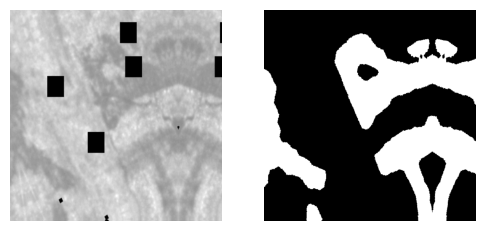

In [8]:



# Apply the augmentations
augmented = augmentations(image=ir_cropped, mask=mask_cropped)

# Separate the image and mask
frag_crop, mask_crop = augmented["image"], augmented["mask"]
# frag_crop, mask_crop = ir_cropped, mask_cropped

print(np.max(ir_cropped), np.max(frag_crop), frag_crop.shape, mask_crop.shape)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(frag_crop, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_crop, cmap="gray")
plt.axis("off")
plt.show()

In [9]:
# del fragment, fragment_cropped, mask_cropped, ir_cropped
# gc.collect()

### Dataloaders

In [10]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [11]:



class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface>0.001) / (surface.shape[0] * surface.shape[1]) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
            A.RandomSizedCrop(min_max_height=(1024, CROP_SIZE), height=CROP_SIZE, width=CROP_SIZE, always_apply=True),
            A.Resize(IMAGE_SIZE, IMAGE_SIZE, always_apply=True),
            # A.RandomScale(scale_limit=0.15, p=0.5),
            
            
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Cutout(max_h_size=int(IMAGE_SIZE * 0.02),
                     max_w_size=int(IMAGE_SIZE * 0.02), num_holes=4, p=0.9),
            A.Rotate(limit=90, p=0.8),
            
            A.Cutout(max_h_size=int(IMAGE_SIZE * 0.05),
                     max_w_size=int(IMAGE_SIZE * 0.05), num_holes=4, p=0.7),
            A.Rotate(limit=90, p=0.8),
            
            A.Cutout(max_h_size=int(IMAGE_SIZE * 0.1),
                     max_w_size=int(IMAGE_SIZE * 0.1), num_holes=4, p=0.7),
            
            A.Cutout(max_h_size=int(IMAGE_SIZE * 0.15),
                     max_w_size=int(IMAGE_SIZE * 0.15), num_holes=2, p=0.7),
            A.Rotate(limit=90, p=0.8),
            
            A.OneOf([
                    A.GaussNoise(var_limit=[0.02, 0.1]),
                    A.GaussianBlur(),
                    A.MotionBlur(),
                    ], p=0.4),
            
            A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
            A.Transpose(p=0.5),
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.RandomContrast(p=0.5),
            A.RandomGamma(p=0.5),
            ToTensorV2(transpose_mask=True),
            
            ]
        
        # self.train_aug_list = [
        #         # A.RandomResizedCrop(
        #         #     size, size, scale=(0.85, 1.0)),
                
        #         A.HorizontalFlip(p=0.5),
        #         A.VerticalFlip(p=0.5),
                
        #         # A.RandomBrightnessContrast(p=0.75),
        #         # A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
        #         #                 mask_fill_value=0, p=0.5),
        #         # A.ShiftScaleRotate(p=0.75),
                
        #         A.Rotate(limit=90, p=0.9), 
                
        #         # A.OneOf([
        #         #         A.GaussNoise(var_limit=[1, 5]),
        #         #         A.GaussianBlur(),
        #         #         A.MotionBlur(),
        #         #         ], p=0.4),
        #         # A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
        #         # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
        #         #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
        #         # A.Normalize(
        #         #     mean= [0] * Z_DIMS,
        #         #     std= [1] * Z_DIMS
        #         # ),
                
                
        #         ToTensorV2(transpose_mask=True),
        #     ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        # take random Z_DIMS integers between 0 and Z_END, without repeating
        # z_slices = np.random.choice(np.arange(8, Z_END), Z_DIMS, replace=False)
        # # sort them
        # z_slices = np.sort(z_slices)
        
        x_offset = random.randint(-600 if x1 != 0 else 0, 600)
        y_offset = random.randint(-600 if y1 != 0 else 0, 600)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        # frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        
        if np.random.uniform(0, 1) > 0.5:
            frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, 1:Z_DIMS*2+1][:, :, ::2]
        else:
            frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, 0:Z_DIMS*2  ][:, :, ::2]
            
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # # take z_slices
        # # Retrieve the crops
        # frag_crop = []

        # for z in z_slices:
        #     frag_slice = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z]
        #     frag_crop.append(frag_slice)

        # # Convert to numpy arrays
        # frag_crop = np.array(frag_crop)
        
        # # permpute the axes: (z, y, x) -> (y, x, z)
        # frag_crop = np.transpose(frag_crop, (1, 2, 0))
        
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        
        
        
        if np.random.uniform(0, 1) < 0.5:
            # Apply the augmentations
            augmented = self.augmentations(image=frag_crop, mask=mask_crop)

            # Separate the image and mask
            frag_crop, mask_crop = augmented["image"], augmented["mask"]
        else:
            # Apply the augmentations
            augmented = self.augmentations(image=1-frag_crop, mask=mask_crop)

            # Separate the image and mask
            frag_crop, mask_crop = augmented["image"], augmented["mask"]
            frag_crop = 1-frag_crop
            

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0)
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [12]:
import numpy as np
np.arange(1, 48, 2).shape

(24,)

In [13]:

class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
        self.valid_aug_list = [
            A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1.0),
            ToTensorV2(transpose_mask=True),
            ]
        self.augmentations = A.Compose(self.valid_aug_list)
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        
        
        if np.random.uniform(0, 1) > 0.5:
            frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, 1:int(Z_DIMS*2)+1][:, :, ::2]
        else:
            frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, 0:int(Z_DIMS*2)  ][:, :, ::2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        
        
        

        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.float().unsqueeze(0)
        mask_crop = mask_crop.float().unsqueeze(0)
        
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [14]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=1,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=1,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

tensor(0., dtype=torch.float64) tensor(0.9983, dtype=torch.float64)
torch.Size([24, 512, 512])


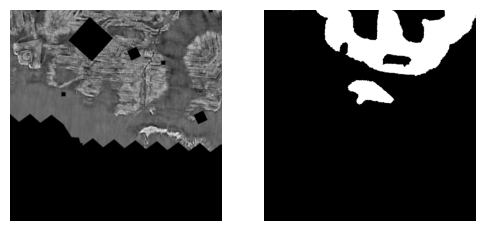

In [15]:
i = random.randint(0, len(dataset_train)-1)
img, mask = dataset_train[i]
print(img.min(), img.max())

x = img[0]
print(x.shape)


plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(x[0], cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask[0], cmap="gray")
plt.axis("off")
plt.show()


10
tensor(0.) tensor(1.)
torch.Size([24, 512, 512])


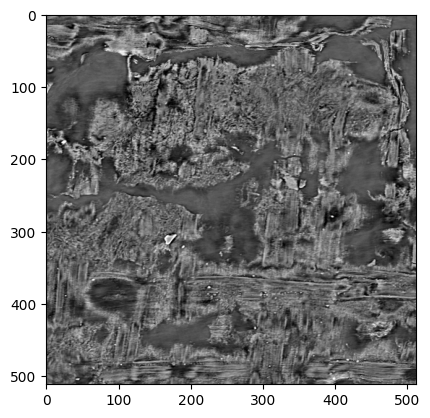

In [16]:
i = random.randint(0, len(dataset_valid)-1)
print(i)
img, mask, _ = dataset_valid[i]
print(img.min(), img.max())

x = img[0]
print(x.shape)
plt.imshow(x[0], cmap="gray")


### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [21]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=18, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        for fp in feat_maps_pooled:x
            print(fp.shape)
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [22]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
# model = nn.DataParallel(model, device_ids=[0])

# model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [24]:
x = torch.randn(5, 1, 16, 512, 512)
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 16, 16])


torch.Size([5, 1, 512, 512])

### Competition metric (F0.5 Score)

In [19]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    # False negatives
    cfm = ((1 - preds) * targets).sum()

    # Recall
    
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (ctp + cfm + smooth)
    fbeta = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return fbeta

### Training

In [20]:
scaler = amp.GradScaler()
# criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
#                                                 steps_per_epoch=40, epochs=EPOCHS//10,
#                                                 pct_start=0.1)

In [21]:
import segmentation_models_pytorch as smp
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()


def fbeta_loss(y_pred, y_true, beta=0.5, smooth=1e-5):
    
    ctp = (y_pred * y_true).sum(dim=0)
    cfp = (y_pred * (1 - y_true)).sum(dim=0)
    cfn = ((1 - y_pred) * y_true).sum(dim=0)

    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (ctp + cfn + smooth)
    fbeta = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return -fbeta.mean()

def criterion(y_pred, y_true):
    # return fbeta_loss(y_pred, y_true)
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)

In [22]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [23]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [24]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    # cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            loss.backward()
            optimizer.step()
            
            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, LR,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    # scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        
        
        
        for j, xy in enumerate(xys):
            # resize pred_masks[j, 0] from (IMAGE_SIZE, IMAGE_SIZE) to (CROP_SIZE, CROP_SIZE) using albumentations
            upsampled_pred_masks = cv2.resize(pred_masks[j, 0].cpu().numpy(), (CROP_SIZE, CROP_SIZE)).astype(np.float32)
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = torch.tensor(upsampled_pred_masks, device='cuda', dtype=torch.float32)

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    out = {
        'train_loss': mloss_train / n_train,
        'val_loss': mloss_val / n_valid,
    }
    
    for threshold in np.arange(0.2, 1.00, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        out[f'fbeta_{threshold:.2f}'] = fbeta.item()
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    out["epoch"] = epoch
    df_out = pd.DataFrame(out, index=[0])
    
    if epoch == 1:
        !rm resnet18_3d_seg.csv
        df_out.to_csv("resnet18_3d_seg.csv", index=False)
    else:
        # first read the old csv file
        df_old = pd.read_csv("resnet18_3d_seg.csv")
        # append the new row to it
        df_new = pd.concat([df_old, df_out], ignore_index=True)
        # save the new csv file
        df_new.to_csv("resnet18_3d_seg.csv", index=False)

    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break


Epoch 1/300  Mem : 22.6GB  LR : 4.00E-06  Loss: 0.6851:  44%|████▍     | 4/9 [00:36<00:45,  9.02s/it]


KeyboardInterrupt: 

In [27]:
df_out

,train_loss,val_loss,fbeta_0.20,fbeta_0.25,fbeta_0.30,fbeta_0.35,fbeta_0.40,fbeta_0.45,fbeta_0.50,fbeta_0.55,fbeta_0.60,fbeta_0.65,fbeta_0.70,fbeta_0.75,fbeta_0.80
0,0.716818,0.672209,"tensor(0.1637, device='cuda:0')","tensor(0.1637, device='cuda:0')","tensor(0.1676, device='cuda:0')","tensor(0.2288, device='cuda:0')","tensor(0.2454, device='cuda:0')","tensor(0.2587, device='cuda:0')","tensor(0.2675, device='cuda:0')","tensor(0.0734, device='cuda:0')","tensor(0.0005, device='cuda:0')","tensor(0., device='cuda:0')","tensor(0., device='cuda:0')","tensor(0., device='cuda:0')","tensor(0., device='cuda:0')"
